<a href="https://colab.research.google.com/github/elenasofia98/PracticalNLP-2023-2024/blob/main/HoL06_1_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec

https://web.stanford.edu/~jurafsky/slp3/6.pdf

Roots:
Vector semantics is the standard way to represent word meaning in NLP.

Osgood’s 1957: to use a point in three-dimensional space to represent the
connotation of a word


Joos (1950), Harris (1954), and Firth (1957): define the meaning of a word by its distribution in language use, meaning its neighboring words or grammatical environments.

Their idea was that two words that occur in very similar distributions (whose neighboring words are similar) have similar meanings.


The idea of vector semantics is to represent a word as a point in a multidimensional semantic space that is derived from the distributions of
embeddings word neighbors.

Vectors for representing words are called embeddings (although
the term is sometimes more strictly applied only to dense vectors like word2vec, rather than sparse tf-idf or PPMI vectors).


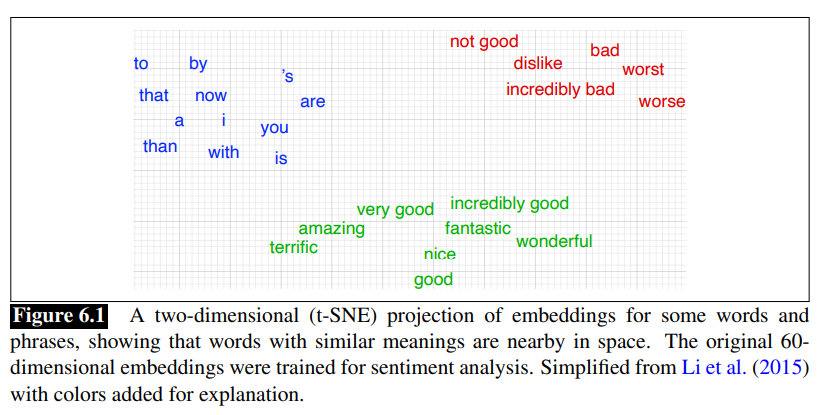

We should take a look first to tf-idf
model, an important baseline, the meaning of a word is defined by a simple function
of the counts of nearby words.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, string

In [3]:
df_train = pd.read_csv('SpookyAuthorIdentification_train.csv')
# df_test = pd.read_csv('data/SpookyAuthorIdentification/test.csv')

pd.set_option('display.max_colwidth', None)
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [4]:
import random
import math

random.seed(42)
index = df_train.index.tolist()
random.shuffle(index)

df_train = df_train.iloc[index].reset_index(drop=True)
index = df_train.index.tolist()
display(df_train.head())


i = math.ceil((len(index)/100)*80)
train_index = index[0:i]
test_index = index[i:]

df_test = df_train.iloc[test_index]
df_train = df_train.iloc[train_index]

len(df_train), len(df_test)

,id,text,author
0,id10914,"It will have been, by that time, totally destroyed, at three different periods, by three successive earthquakes.",EAP
1,id03295,"Make me happy, and I shall again be virtuous.""",MWS
2,id04103,"The margin of the river, and of the many dazzling rivulets that glided through devious ways into its channel, as well as the spaces that extended from the margins away down into the depths of the streams until they reached the bed of pebbles at the bottom, these spots, not less than the whole surface of the valley, from the river to the mountains that girdled it in, were carpeted all by a soft green grass, thick, short, perfectly even, and vanilla perfumed, but so besprinkled throughout with the yellow buttercup, the white daisy, the purple violet, and the ruby red asphodel, that its exceeding beauty spoke to our hearts in loud tones, of the love and of the glory of God.",EAP
3,id26189,The heat became all at once intolerable.,EAP
4,id07955,"What, indeed, was my passion for the young girl of the valley in comparison with the fervor, and the delirium, and the spirit lifting ecstasy of adoration with which I poured out my whole soul in tears at the feet of the ethereal Ermengarde?",EAP


(15664, 3915)

In [5]:
dataset = {'train': df_train, 'test': df_test}

In [6]:
# https://www.nltk.org/api/nltk.tokenize.html
from nltk.tokenize import word_tokenize
import re

import nltk
nltk.download('punkt')


for split in ['train', 'test']:
    dataset[split]['clean_text'] = dataset[split]['text'].apply(lambda x: x.lower())
    dataset[split]['tokens'] = dataset[split]['clean_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Co-occurences matrix: sparse vectors
We build term-term matrix, also called the word-word matrix or the term-context matrix, in which the columns are labeled by words.

This matrix is thus of dimensionality |V|×|V| and each cell records
the number of times the row (target) word and the column (context) word co-occur in some context in some training corpus.

Note that |V|, the dimensionality of the vector, is generally the size of the vocabulary

In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = dataset['train']['text']

count_model = CountVectorizer(ngram_range=(1,1), stop_words=stopwords.words('english')) # default unigram model
count_model.fit(corpus)

encoded_corpus = count_model.transform(corpus)
encoded_corpus.shape

(15664, 22880)

In [9]:
print(encoded_corpus[0].todense().tolist())
np.sum(encoded_corpus.todense()[0]>=1, axis=1)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

matrix([[8]])

In [35]:
X = (encoded_corpus.T * encoded_corpus) # this is co-occurrence matrix in sparse csr format
X.setdiag(0) # sometimes you want to fill same word cooccurence to 0
print(X.shape)
X = np.array(X.todense())
X

(22880, 22880)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
'dog' in count_model.get_feature_names_out(), 'cat' in count_model.get_feature_names_out()

(True, True)

In [43]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

idog = np.where(count_model.get_feature_names_out() == 'dog')[0][0]
icat = np.where(count_model.get_feature_names_out() == 'pet')[0][0]

cos_sim(X[idog], X[icat])

0.09545941546018391

# Word2vec

Embeddings, short dense
vectors. Unlike the vectors we’ve seen so far, embeddings are short, with number
of dimensions d ranging from 50-1000, rather than the much larger vocabulary size |V| or number of documents D we’ve seen.

These d dimensions don’t have a clear
interpretation. And the vectors are dense: instead of vector entries being sparse,
mostly-zero counts or functions of counts, the values will be real-valued numbers
that can be negative.


Word2vec embeddings are static embeddings, meaning that the method learns one fixed embedding for each word in the static
embeddings
vocabulary.

The intuition of word2vec is that instead of counting how often each word w occurs near, say, apricot, we’ll instead train a classifier on a binary prediction task: “Is
word w likely to show up near apricot?” We don’t actually care about this prediction
task; instead we’ll take the learned classifier weights as the word embeddings.

The revolutionary intuition here is that we can just use running text as implicitly
supervised training data for such a classifier.

This method, often called self-supervision, avoids the need for
any sort of hand-labeled supervision signal.

This idea was first proposed in the task of neural language modeling.
A neural language model (a neural network that learned to predict the
next word from prior words) could just use the next word in running text as its supervision signal, and could be used to learn an embedding representation for each word as part of doing this prediction task.


https://www.baeldung.com/cs/ml-word2vec-topic-modeling

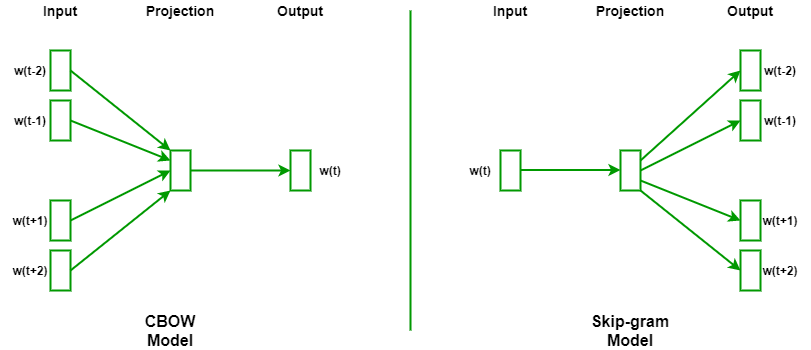

## Classifier

Our goal is to train a classifier such that, given a tuple $(w, c)$ of a target word
w paired with a candidate context word c (for example (apricot, jam), or perhaps
(apricot, aardvark)) it will return the probability that c is a real context word (true
for jam, false for aardvark):

$P(+|w, c)$

For word that are not in the context:
$P(−|w, c) = 1−P(+|w, c)$

How does the classifier compute the probability P?

The intuition of the skipgram model is to base this probability on embedding similarity: a word is likely to
occur near the target if its embedding vector is similar to the target embedding.

To compute similarity between these dense embeddings, we rely on the intuition that
two vectors are similar if they have a high dot product (after all, cosine is just a
normalized dot product).


In other words:
$Similarity(w, c) ≈ c ·w$

The dot product c · w is not a probability, it’s just a number ranging from $-∞$  to $+∞$
(since the elements in word2vec embeddings can be negative, the dot product can be
negative).

To turn the dot product into a probability, we’ll use the logistic or sigmoid function:

$σ(x) = \frac{1}{1+exp(−x)}$

NB:
$P(+|w, c) = σ(x)$

$P(−|w, c) = 1−P(+|w, c) = 1 - σ(x) = σ(-x)$

Equation 6.28 gives us the probability for one word, but there are many context
words in the window.

Skip-gram makes the simplifying assumption that all context
words are independent, allowing us to just multiply their probabilities:

$P(+|w, c[1:L]) = ∏_{1 ≼ i ≼ L} σ(c[i]·w)$